# Case 1
**Neural Networks for Machine Learning Applications**<br>
5.2.2022<br>
Daniel Ridzon<br>
Metropolia University of Applied Sciences

## 1. Introduction

In this notebook, we are processing the Heart Disease Health Indicators Dataset with neural networks.  
We have tested many different hyperparameter settings to achive the best possible results.

## 2. Setup

Below are listed all needed libraries and their version numbers.

In [1]:
# libraries import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk
import time


from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import ParameterGrid

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import plot_model

# Make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

# Print the version numbers
print("pandas:    ", pd.__version__)
print("numpy:     ", np.__version__)
print("seaborn:   ", sns.__version__)
print("matplotlib:", matplotlib.__version__)
print("tensorflow:", tf.__version__)
print("keras:     ", keras.__version__)
print("sklearn:   ", sk.__version__)

pandas:     1.3.4
numpy:      1.20.3
seaborn:    0.11.2
matplotlib: 3.4.3
tensorflow: 2.7.0
keras:      2.7.0
sklearn:    0.24.2


## 3. Dataset

In [2]:
# Load the dataset into pandas dataframe object.
df = pd.read_csv("heart_disease_health_indicators_BRFSS2015.csv", sep="\s*,\s*", engine="python")

# Print info about the dataset.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
HeartDiseaseorAttack,253680.0,0.094186,0.292087,0.0,0.0,0.0,0.0,1.0
HighBP,253680.0,0.429001,0.494934,0.0,0.0,0.0,1.0,1.0
HighChol,253680.0,0.424121,0.494210,0.0,0.0,0.0,1.0,1.0
CholCheck,253680.0,0.962670,0.189571,0.0,1.0,1.0,1.0,1.0
BMI,253680.0,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0
Smoker,253680.0,0.443169,0.496761,0.0,0.0,0.0,1.0,1.0
Stroke,253680.0,0.040571,0.197294,0.0,0.0,0.0,0.0,1.0
Diabetes,253680.0,0.296921,0.698160,0.0,0.0,0.0,0.0,2.0
PhysActivity,253680.0,0.756544,0.429169,0.0,1.0,1.0,1.0,1.0
Fruits,253680.0,0.634256,0.481639,0.0,0.0,1.0,1.0,1.0


### Checking balance of the target values

Ratio of healthy people in the dataset: 0.9058144118574583
Ratio of sick in people in the dataset: 0.09418558814254178


<AxesSubplot:>

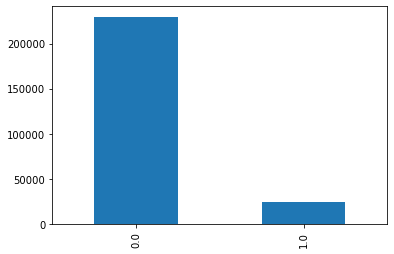

In [3]:
# Check what is the ratio between records with positive and negative target value.
zeros = df['HeartDiseaseorAttack'].value_counts()[0]
ones = df['HeartDiseaseorAttack'].value_counts()[1]
zero_ratio = zeros/len(df.index)
one_ratio = ones/len(df.index)

# Print ratio of target binary labels.
print(f"Ratio of healthy people in the dataset: {zero_ratio}")
print(f"Ratio of sick in people in the dataset: {one_ratio}")

# Plot the ratio.
df["HeartDiseaseorAttack"].value_counts().plot(kind="bar")

From the graph we can clearly see, that the target labels are very unbalanced,  
we will have to use class weights in the NN model, to fix the balance.  
Otherwise the NN will tend to output just 0 labels to maximalize training accuracy.

### Checking for correlation between features

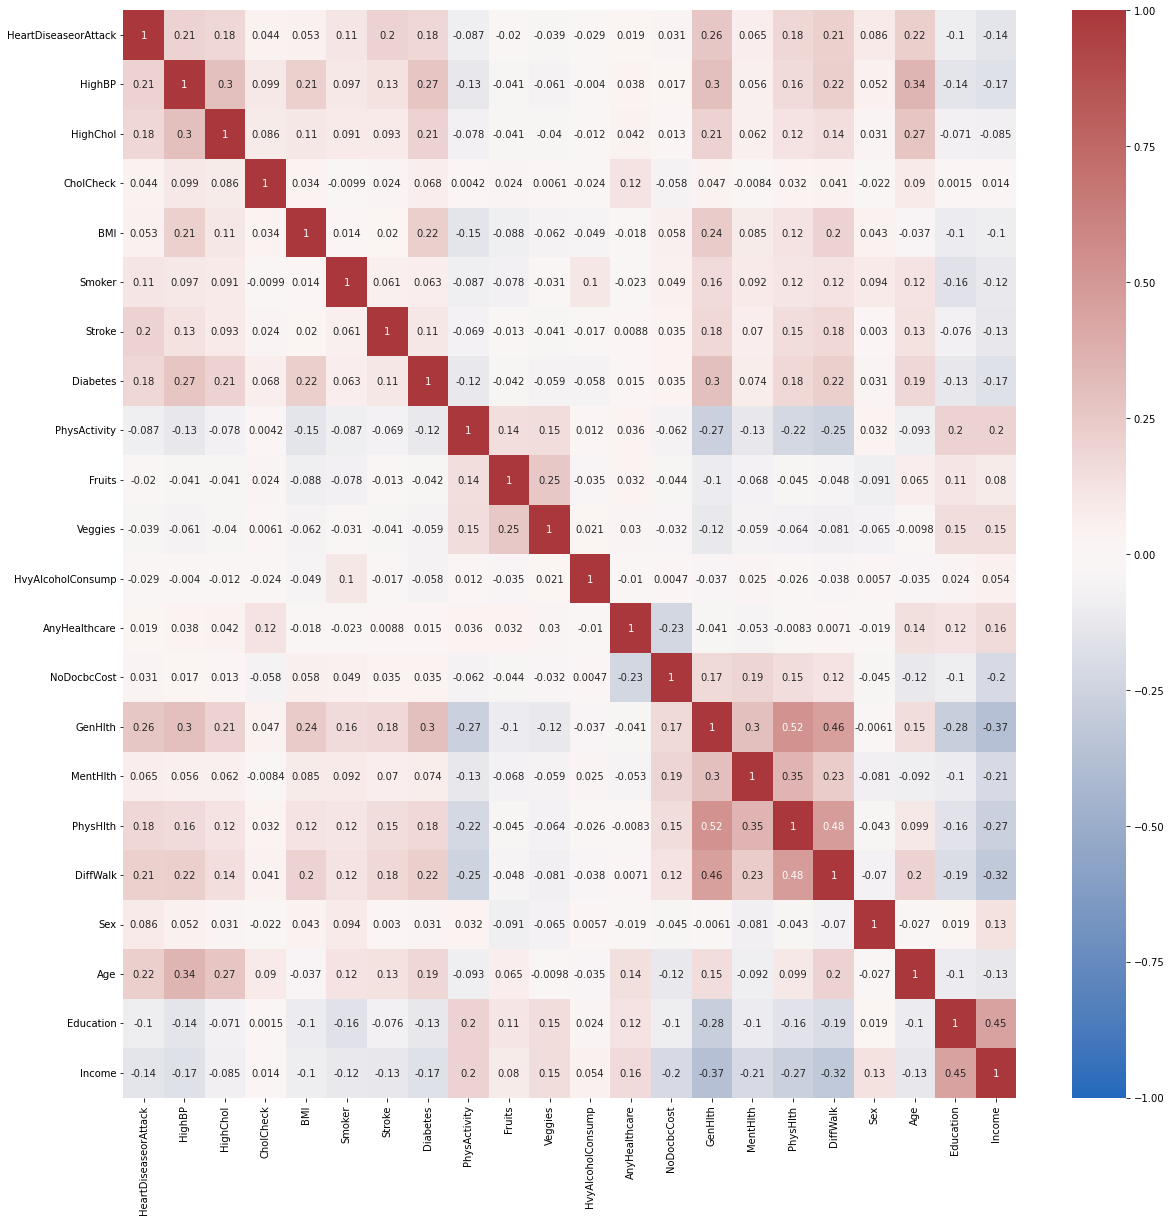

In [4]:
# Plotting the correlation heatmap
plt.figure(figsize=(20,20))
dataplot = sns.heatmap(df.corr(), cmap="vlag", annot=True, vmin=-1, vmax=1)
  
# Displaying the heatmap
plt.show()

There are no tightly correlated features in the dataset (fetures with correlations < -0.7 or > 0.7).  
If there would be any such features, we should drop one of these features from the dataframe,  
as it makes model more robust and quicker to fit the data.

## 4. Preprocessing

### Fixing missing values in dataset

In [5]:
df.isna().sum().sum()

0

Dataset has no missing values, so we dont neeed to do anything with them.

### Split dataset into train validation and test subsets

In [6]:
# Split the data into train (60%), validation (20%) and test datasets (20%)
train_df, validation_df, test_df = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])

print(f"train: {len(train_df.index)}, validation: {len(validation_df.index)}, test: {len(test_df.index)}")

train: 152208, validation: 50736, test: 50736


### Separate features and labels

In [7]:
# Separate features and labels
train_features = train_df.copy()
validation_features = validation_df.copy()
test_features = test_df.copy()

train_labels = train_features.pop("HeartDiseaseorAttack")
validation_labels = validation_features.pop("HeartDiseaseorAttack")
test_labels = test_features.pop("HeartDiseaseorAttack")

FEATURES = len(train_features.columns)
print("Number of features:", FEATURES)

Number of features: 21


### Normalize features

In [8]:
# Create normalization layer for the model.
normalizer = layers.Normalization()
normalizer.adapt(np.array(train_features))

### Class weights

In [9]:
# Because our dataset is very inbalanced, we need to balance the postive results, so there is same amount of them as of the negative ones.
class_weight = {
    0: one_ratio,
    1: zero_ratio
}
class_weight

{0: 0.09418558814254178, 1: 0.9058144118574583}

## 5. Modeling

### Prepare different configurantion

In [10]:
# Define different hyperparameter combinations, to test how specific changes influence final result.
param_grid = [
    {
        "use_dropout": [True, False]
    },
    {
        "activation_fnc": ["relu", "selu", "elu"],
    },
    {
        "optimizer": ["sgd", "adam"],
    }
    
]

param_comb = list(ParameterGrid(param_grid))

# Set default values to the parameters
for param in param_comb:
    param.setdefault("use_dropout", True)
    param.setdefault("activation_fnc", "relu")
    param.setdefault("optimizer", "adam")

# Remove duplicate configurations
param_comb = [i for n, i in enumerate(param_comb) if i not in param_comb[n + 1:]]

### Create models from parameters

In [11]:
models = []

# Iterate through parameters and crate corresponding models
for param in param_comb:

    model_class_weight = {
        0: class_weight[0],
        1: class_weight[1]
    }

    activation_fnc = param.get("activation_fnc", "relu")

    # Create the NN model
    if param.get("use_dropout", True):
        model = keras.Sequential(
            [
                normalizer,
                layers.Dropout(0.8, input_shape=(21,), name = "dropout"),
                layers.Dense(FEATURES, activation = activation_fnc, name = "input"),
                layers.Dropout(0.5, input_shape=(21,), name = "dropout1"),
                layers.Dense(20, activation = activation_fnc, name = "hidden_1"),
                layers.Dropout(0.5, input_shape=(21,), name = "dropout2"),
                layers.Dense(20, activation = activation_fnc, name = "hidden_2"),
                layers.Dropout(0.5, input_shape=(21,), name = "dropout3"),
                layers.Dense(20, activation = activation_fnc, name = "hidden_3"),
                layers.Dropout(0.5, input_shape=(21,), name = "dropout4"),
                layers.Dense(20, activation = activation_fnc, name = "hidden_4"),
                layers.Dropout(0.5, input_shape=(21,), name = "dropout5"),
                layers.Dense(10, activation = activation_fnc, name = "hidden_5"),
                layers.Dense(1, activation = "sigmoid", name = "output")
            ]
        )

    else:
        model = keras.Sequential(
            [
                normalizer,
                layers.Dense(FEATURES, activation = activation_fnc, name = "input"),
                layers.Dense(20, activation = activation_fnc, name = "hidden_1"),
                layers.Dense(20, activation = activation_fnc, name = "hidden_2"),
                layers.Dense(20, activation = activation_fnc, name = "hidden_3"),
                layers.Dense(20, activation = activation_fnc, name = "hidden_4"),
                layers.Dense(10, activation = activation_fnc, name = "hidden_5"),
                layers.Dense(1, activation = "sigmoid", name = "output")
            ]
        )

    optimizer = optimizers.SGD() if param.get("optimizer", "adam") == "sgd" else optimizers.Adam()

    # Compile the model.
    model.compile(
        loss=losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()]
    )

    # Print the summary of the model.
    print(f"-------\n{param}\n\n{model.summary()}")
    
    models.append({
        "model": model,
        "params": param,
        "class_weight": model_class_weight
    })

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 21)               43        
 n)                                                              
                                                                 
 input (Dense)               (None, 21)                462       
                                                                 
 hidden_1 (Dense)            (None, 20)                440       
                                                                 
 hidden_2 (Dense)            (None, 20)                420       
                                                                 
 hidden_3 (Dense)            (None, 20)                420       
                                                                 
 hidden_4 (Dense)            (None, 20)                420       
                                                        

## 6. Training

In [12]:
EPOCHS = 200
VERBOSE = 0

In [13]:
for model_data in models:

    print(f"Training model: {model_data} ...\n")

    # Save the start time of the algorithm.
    start_time = time.time()

    # Fit the model
    h = model_data["model"].fit(
        train_features,
        train_labels,
        epochs = EPOCHS,
        verbose = VERBOSE,
        validation_data=(validation_features, validation_labels),
        class_weight=model_data["class_weight"],
    )

    # Measure training time.
    total_time = time.time() - start_time

    # Save the results
    model_data["history"] = h
    model_data["training_time"] = total_time

Training model: {'model': <keras.engine.sequential.Sequential object at 0x000001778A7411C0>, 'params': {'use_dropout': False, 'activation_fnc': 'relu', 'optimizer': 'adam'}, 'class_weight': {0: 0.09418558814254178, 1: 0.9058144118574583}} ...

Training model: {'model': <keras.engine.sequential.Sequential object at 0x0000017788084760>, 'params': {'activation_fnc': 'selu', 'use_dropout': True, 'optimizer': 'adam'}, 'class_weight': {0: 0.09418558814254178, 1: 0.9058144118574583}} ...

Training model: {'model': <keras.engine.sequential.Sequential object at 0x00000177880E8520>, 'params': {'activation_fnc': 'elu', 'use_dropout': True, 'optimizer': 'adam'}, 'class_weight': {0: 0.09418558814254178, 1: 0.9058144118574583}} ...

Training model: {'model': <keras.engine.sequential.Sequential object at 0x000001778812D280>, 'params': {'optimizer': 'sgd', 'use_dropout': True, 'activation_fnc': 'relu'}, 'class_weight': {0: 0.09418558814254178, 1: 0.9058144118574583}} ...

Training model: {'model': <ke

## 7. Performance and evaluation

### Methods for plotting models overview

In [73]:
def print_model_title(params):
    """
    Prints sorted items of a dict
    """
    
    out = ""
    
    for key, val in sorted(params.items()):
        out = f"{out}{', ' if out != '' else ''}{key}: {val}"

    return out

In [74]:

def plot_metrics(models, ylim=[0, 1], metrics=None):
    
    # Measure plot layout based on number of trained models.
    size = int(np.ceil(np.sqrt(len(models))))
    
    # Create plot with subplots.
    fig, axs = plt.subplots(size, size, figsize=(20, 15))
    
    # Enumerate plots and plot each of them
    for n, model in enumerate(models):
        
        row = int(n % size)
        col = int(n / size)
        
        recall_id = "recall"
        if n > 0:
            recall_id = f"recall_{n}"
        
        if metrics == "binary_accuracy" or metrics is None:
            axs[col, row].plot(model["history"].epoch, model["history"].history["binary_accuracy"], label="Tra. Acc.")
            axs[col, row].plot(model["history"].epoch, model["history"].history[f"val_binary_accuracy"], label="Val. Acc.")
        
        if metrics == "loss" or metrics is None:
            axs[col, row].plot(model["history"].epoch, model["history"].history["loss"], label="Tra. Loss.", linestyle="--")
            axs[col, row].plot(model["history"].epoch, model["history"].history[f"val_loss"], label="Val. Loss", linestyle="--")
        
        if metrics == "recall" or metrics is None:
            axs[col, row].plot(model["history"].epoch, model["history"].history[recall_id], label="Tra. Rec.", linestyle="dotted")
            axs[col, row].plot(model["history"].epoch, model["history"].history[f"val_{recall_id}"], label="Val. Rec", linestyle="dotted")

        plt.subplot(size, size, n + 1)
        if metrics is not None:
            plt.ylabel(metrics)
        plt.ylim(ylim)
        plt.xlabel("Epoch")
        plt.title(print_model_title(model["params"]))
        plt.legend()

    plt.show()

In [75]:
def plot_cm(models, test_dataset=False, treshold=0.5):
    """
    Plots confussion matricies
    """
    
    print(f"treshold = {treshold}")
    
    # Measure plot layout based on number of trained models.
    size = int(np.ceil(np.sqrt(len(models))))
    
    # Create plot with subplots.
    fig, axs = plt.subplots(size, size, figsize=(20, 15))
    
    # Enumerate plots and plot each of them
    for n, model in enumerate(models):
        
        # Check which dataset to use.
        if test_dataset:
            features = test_features
            labels = test_labels
        else:
            features = validation_features
            labels = validation_labels
        
        # Evaluate metrics
        predictions_baseline = model["model"].predict(features)
        
        # Create the confusion matrix
        cm = confusion_matrix(labels, predictions_baseline > treshold)
        
        # Measure precision and recall
        true_positive = cm[1, 1]
        true_negative = cm[0, 0]
        false_positive = cm[0, 1]
        false_negative = cm[1, 0]
        
        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)
        accuracy = (true_positive + true_negative) / cm.sum().sum()
        
        print(f"[{print_model_title(model['params'])}] - recall: {recall:.2f} precision: {precision:.2f} accuracy: {accuracy:.2f}")
    
        plt.subplot(size, size, n + 1)
        sns.heatmap(cm, annot=True, fmt="d")
        plt.ylabel("Actual label")
        plt.xlabel("Predicted label")
        plt.title(print_model_title(model["params"]))

    plt.show()

In [76]:
def plot_roc(models, test_dataset=False):
    """
    Plots roc curve for each model.
    """
    
    # Measure plot layout based on number of trained models.
    size = int(np.ceil(np.sqrt(len(models))))
    
    # Create plot with subplots.
    fig, axs = plt.subplots(size, size, figsize=(20, 15))
    
    # Enumerate plots and plot each of them
    for n, model in enumerate(models):
        
        row = int(n % size)
        col = int(n / size)
        
        # Check which dataset to use.
        if test_dataset:
            features = test_features
            labels = test_labels
        else:
            features = validation_features
            labels = validation_labels

        plt.subplot(size, size, n + 1)
        
        # Evaluate metrics
        predictions = model["model"].predict(features).ravel()
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, predictions)
        roc_auc = auc(fpr_keras, tpr_keras)
        
        plt.plot(fpr_keras, tpr_keras, "b", label = f"AUC = {roc_auc:0.2f}")
        plt.ylabel("Actual label")
        plt.xlabel("Predicted label")
        plt.title(print_model_title(model["params"]))

    plt.show()

### Accuracy, Loss, Recall
(Graphs with just one metric are bellow these)

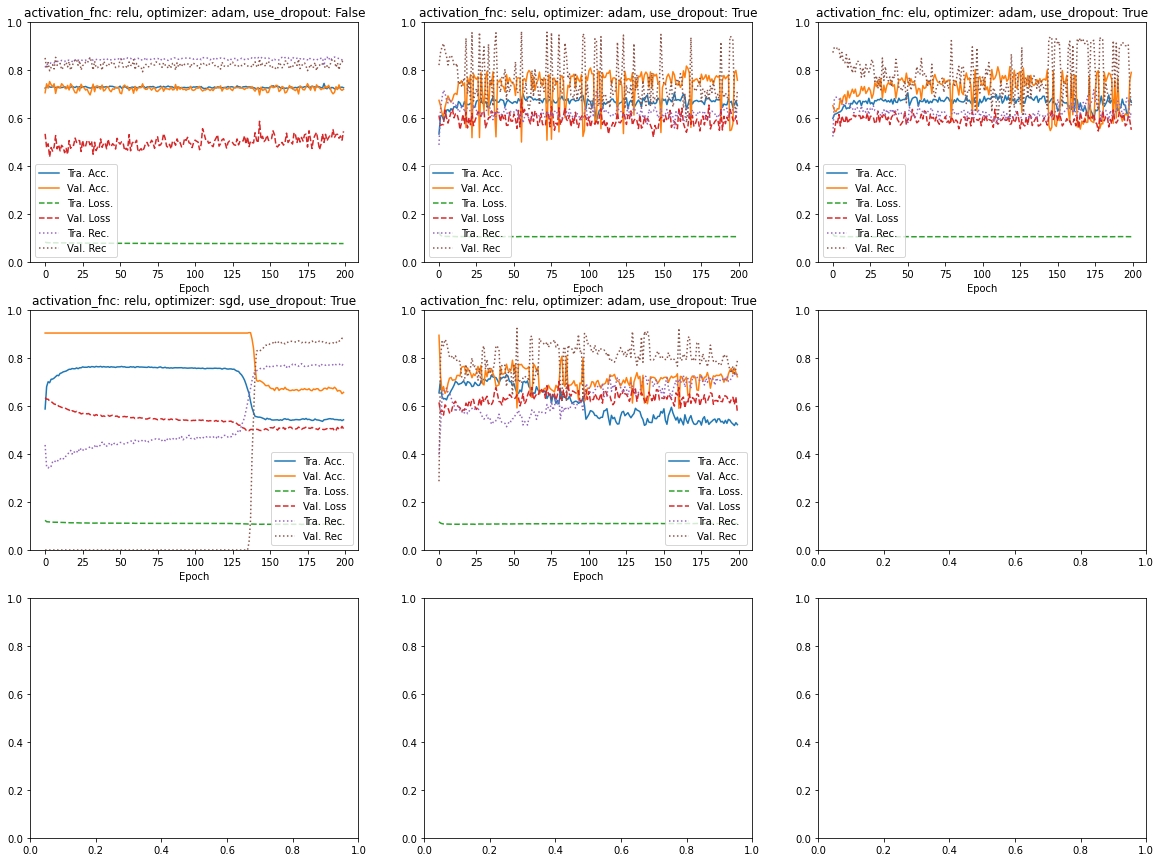

In [77]:
plot_metrics(models)

### Accuracy

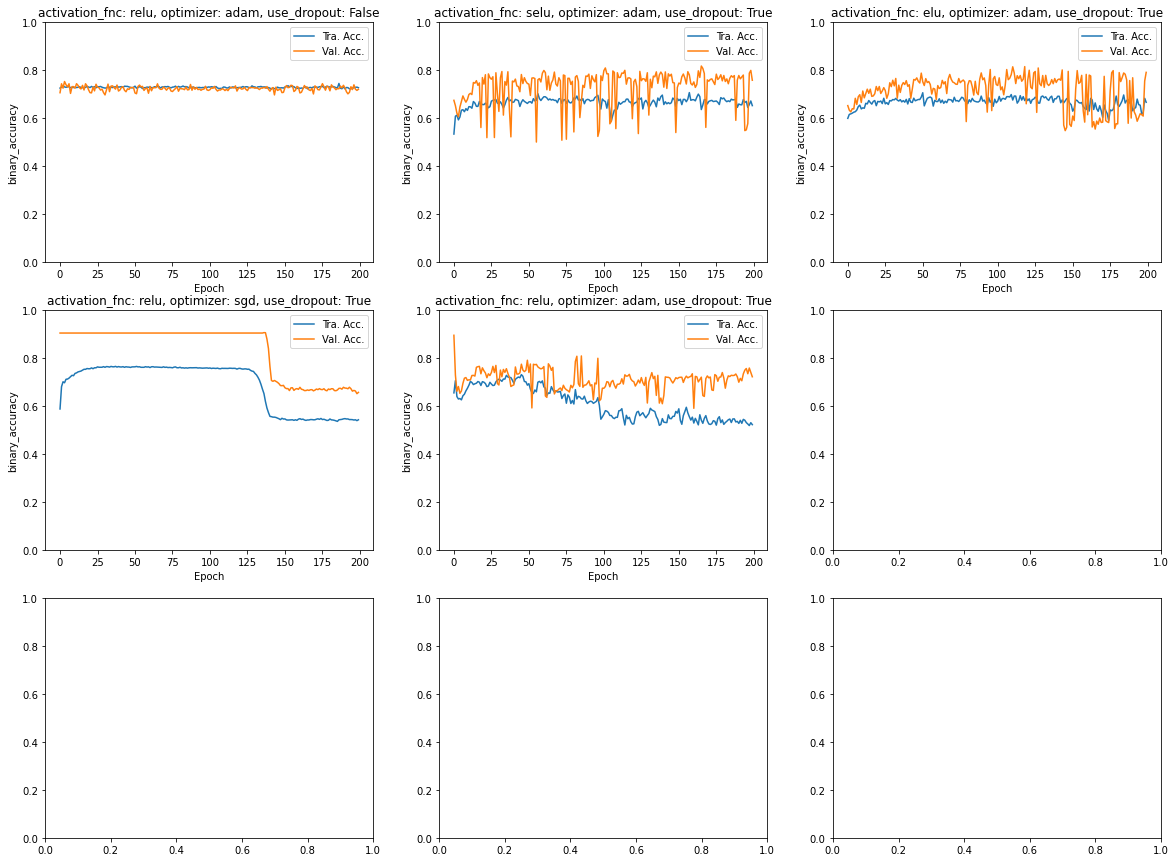

In [78]:
plot_metrics(models, metrics="binary_accuracy")

### Loss

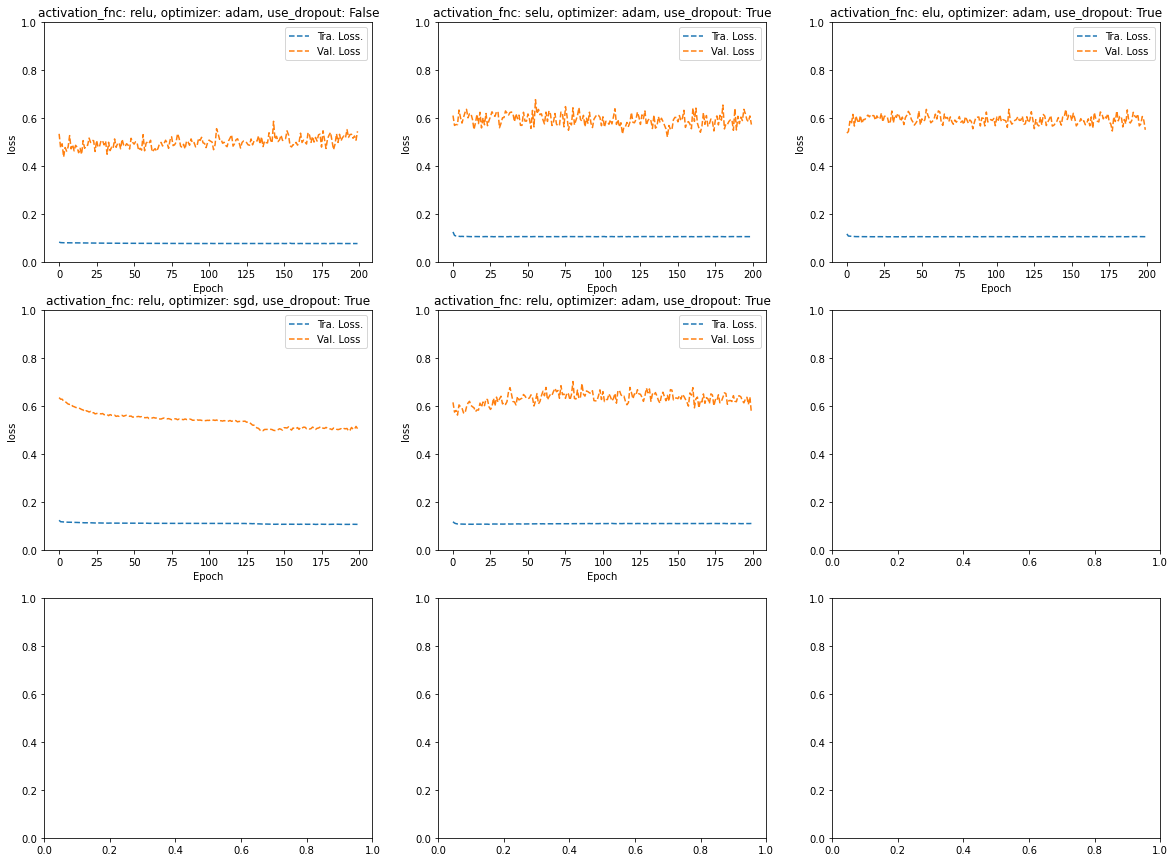

In [79]:
plot_metrics(models, metrics="loss")

### Recall

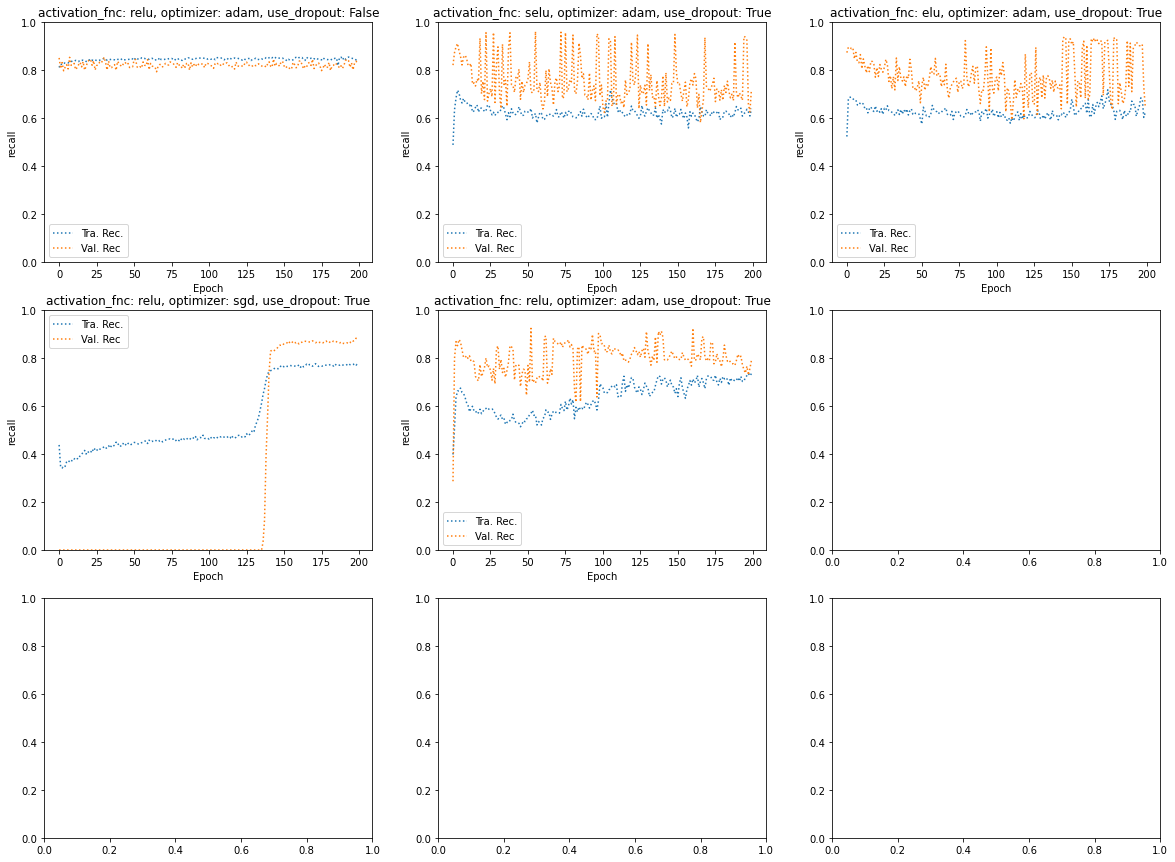

In [80]:
plot_metrics(models, metrics="recall")

### ROC curve

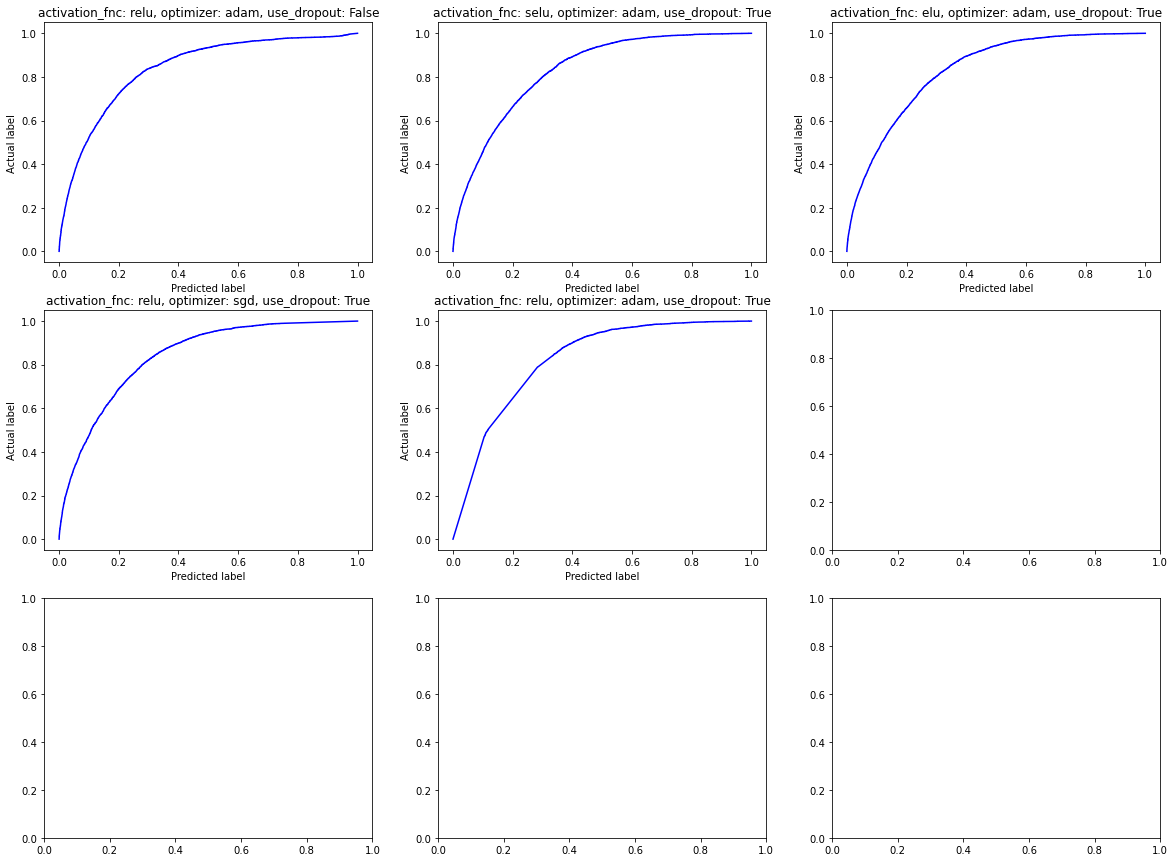

In [81]:
plot_roc(models)

### Confusion matrix

treshold = 0.5
[activation_fnc: relu, optimizer: adam, use_dropout: False] - recall: 0.83 precision: 0.23 accuracy: 0.72
[activation_fnc: selu, optimizer: adam, use_dropout: True] - recall: 0.72 precision: 0.24 accuracy: 0.76
[activation_fnc: elu, optimizer: adam, use_dropout: True] - recall: 0.65 precision: 0.26 accuracy: 0.79
[activation_fnc: relu, optimizer: sgd, use_dropout: True] - recall: 0.88 precision: 0.20 accuracy: 0.66
[activation_fnc: relu, optimizer: adam, use_dropout: True] - recall: 0.79 precision: 0.23 accuracy: 0.72


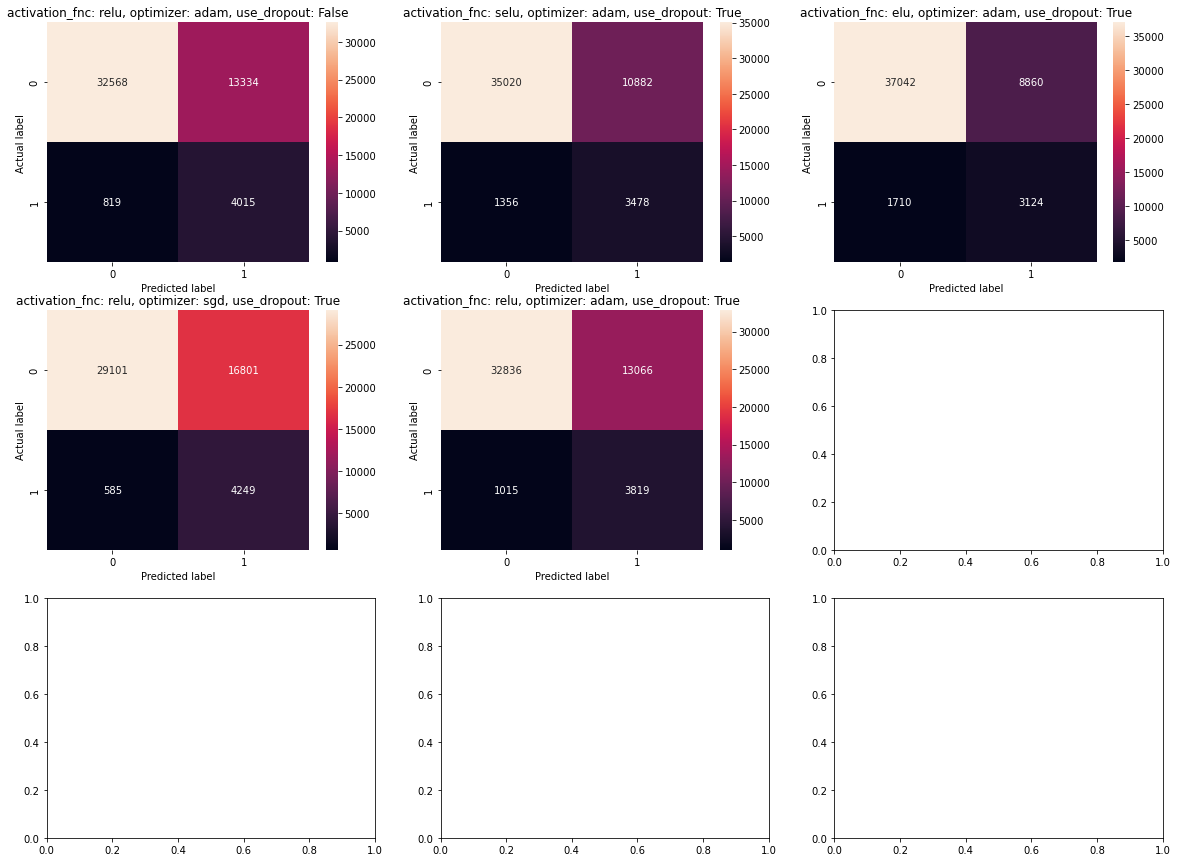

In [82]:
plot_cm(models, treshold=0.5)

treshold = 0.4
[activation_fnc: relu, optimizer: adam, use_dropout: False] - recall: 0.86 precision: 0.21 accuracy: 0.68
[activation_fnc: selu, optimizer: adam, use_dropout: True] - recall: 0.94 precision: 0.17 accuracy: 0.55
[activation_fnc: elu, optimizer: adam, use_dropout: True] - recall: 0.94 precision: 0.16 accuracy: 0.54
[activation_fnc: relu, optimizer: sgd, use_dropout: True] - recall: 0.91 precision: 0.19 accuracy: 0.61
[activation_fnc: relu, optimizer: adam, use_dropout: True] - recall: 0.90 precision: 0.19 accuracy: 0.63


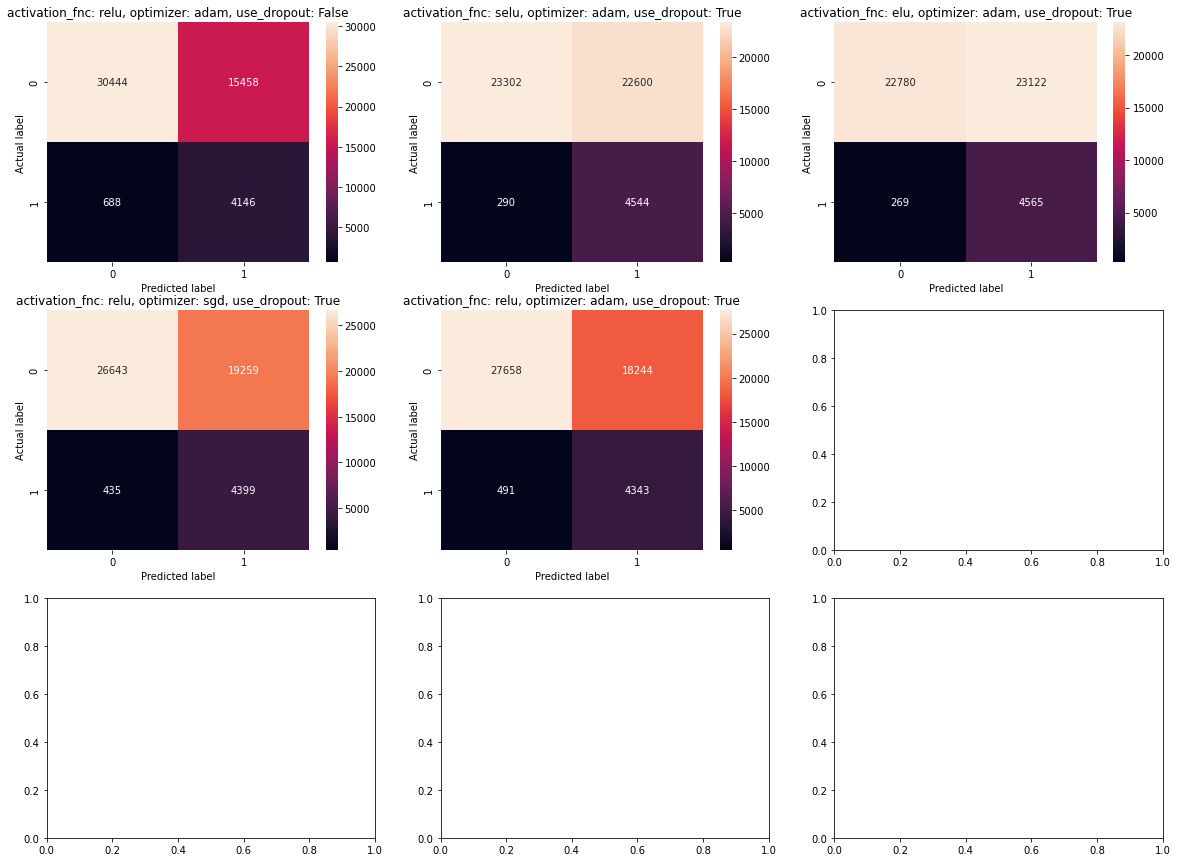

In [83]:
plot_cm(models, treshold=0.40)

treshold = 0.55
[activation_fnc: relu, optimizer: adam, use_dropout: False] - recall: 0.80 precision: 0.25 accuracy: 0.75
[activation_fnc: selu, optimizer: adam, use_dropout: True] - recall: 0.70 precision: 0.25 accuracy: 0.77
[activation_fnc: elu, optimizer: adam, use_dropout: True] - recall: 0.62 precision: 0.27 accuracy: 0.80
[activation_fnc: relu, optimizer: sgd, use_dropout: True] - recall: 0.01 precision: 0.75 accuracy: 0.91
[activation_fnc: relu, optimizer: adam, use_dropout: True] - recall: 0.79 precision: 0.23 accuracy: 0.72


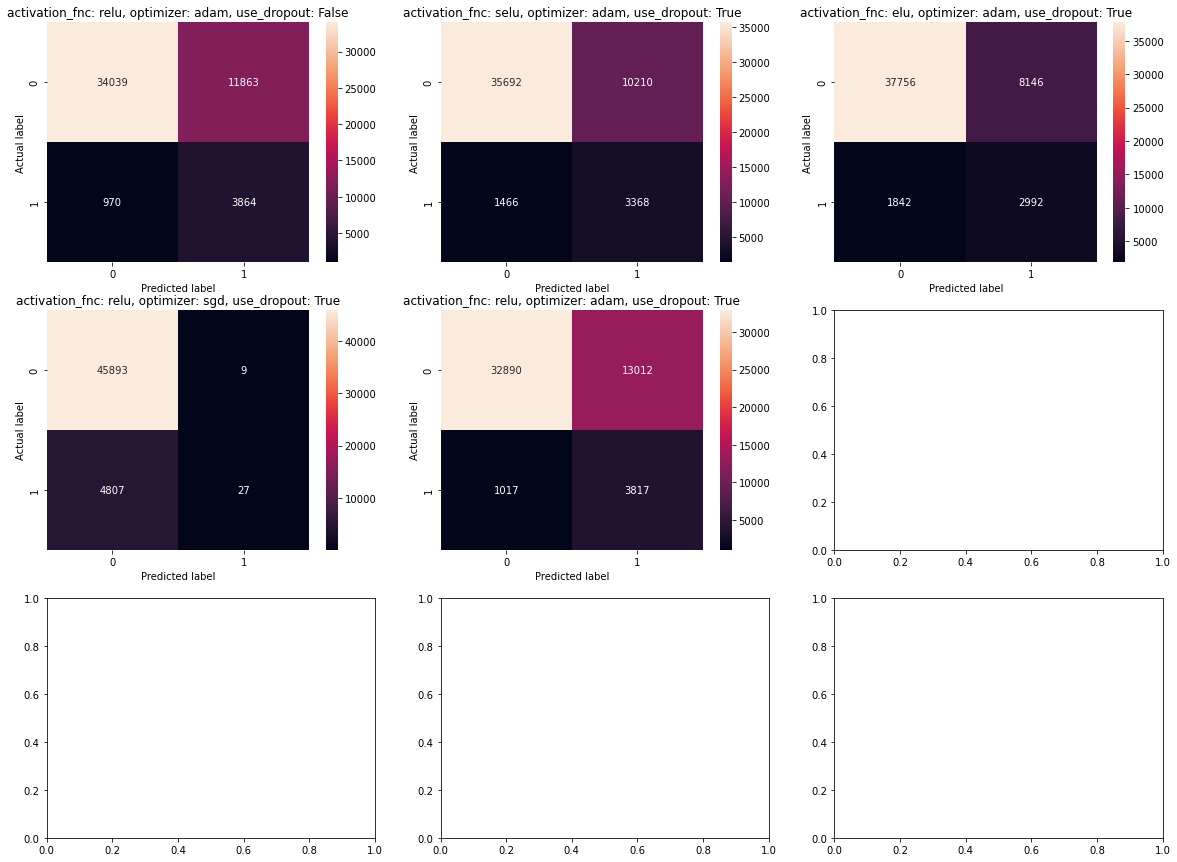

In [84]:
plot_cm(models, treshold=0.55)

### Training time

In [85]:
for model in models:
    print(f"[{print_model_title(model['params'])}]:     {model['training_time']:.0f}s")

[activation_fnc: relu, optimizer: adam, use_dropout: False]:     1133s
[activation_fnc: selu, optimizer: adam, use_dropout: True]:     1355s
[activation_fnc: elu, optimizer: adam, use_dropout: True]:     1373s
[activation_fnc: relu, optimizer: sgd, use_dropout: True]:     1191s
[activation_fnc: relu, optimizer: adam, use_dropout: True]:     1324s


None of the used configurations significantly influenced training time.

## 8. Discussion and conclusions

### Ideal result
As we are predicting chance for hearth disease, it is good to aim for high recall without loosing too much precision (To have most of the true positives, but not have huge amount of false positives).

### Observations
In prior testing I have found out that using neural network model with 5 hidden dense layers with 20 neurons outputs pretty good results.  
Then I tested changing different model conffigurations: changing activation function, optimizer and whether to use droupout in training.

I have achieved best results while using ReLU activation function and Adam optimizer regardless on use of dropout.  
(Dropout just increased number of epochs to achieve same accuracy as model without it. Model without dropout had consistent output since the first few epochs.)

Similar score on the output had model with sgd optimizer, relu activation and dropout. But during the first 135 epochs it had very bad output.

I got the worst results with using SeLu and ReLU activation function. Also the validation metrics wasnt very consistant, sometimes they had random jumps.


### Conclusion
From my testing, the best model is the one with ReLU activation function, Adam optimizer without dropout, as it got to the best functionality in small number of epochs.

### Moving the prediction treshold
It is possible to move the prediction (default value at 0.5) down to achieve higher recall in cost of less precision, or move it up for opposite results.


## 9. Testing the final model.

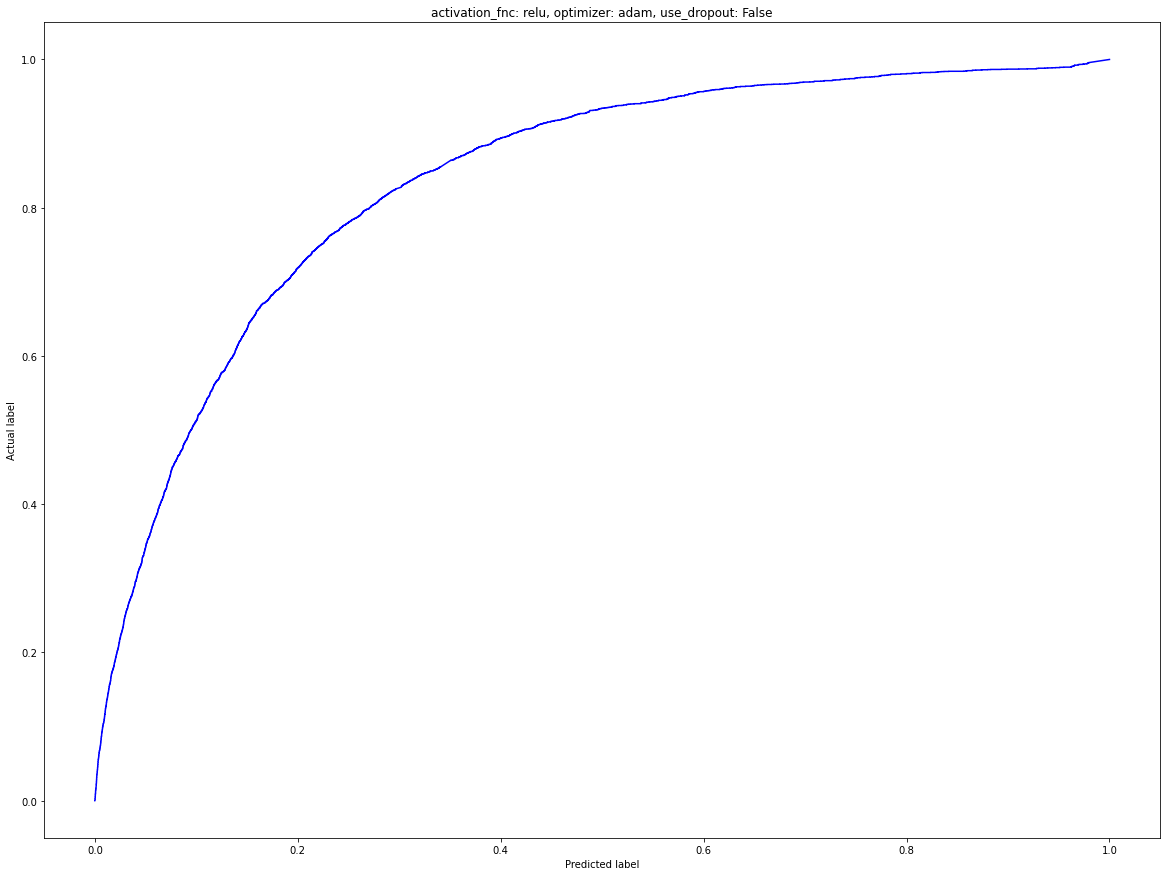

In [86]:
plot_roc([models[0]], test_dataset=True)

treshold = 0.5
[activation_fnc: relu, optimizer: adam, use_dropout: False] - recall: 0.82 precision: 0.23 accuracy: 0.72


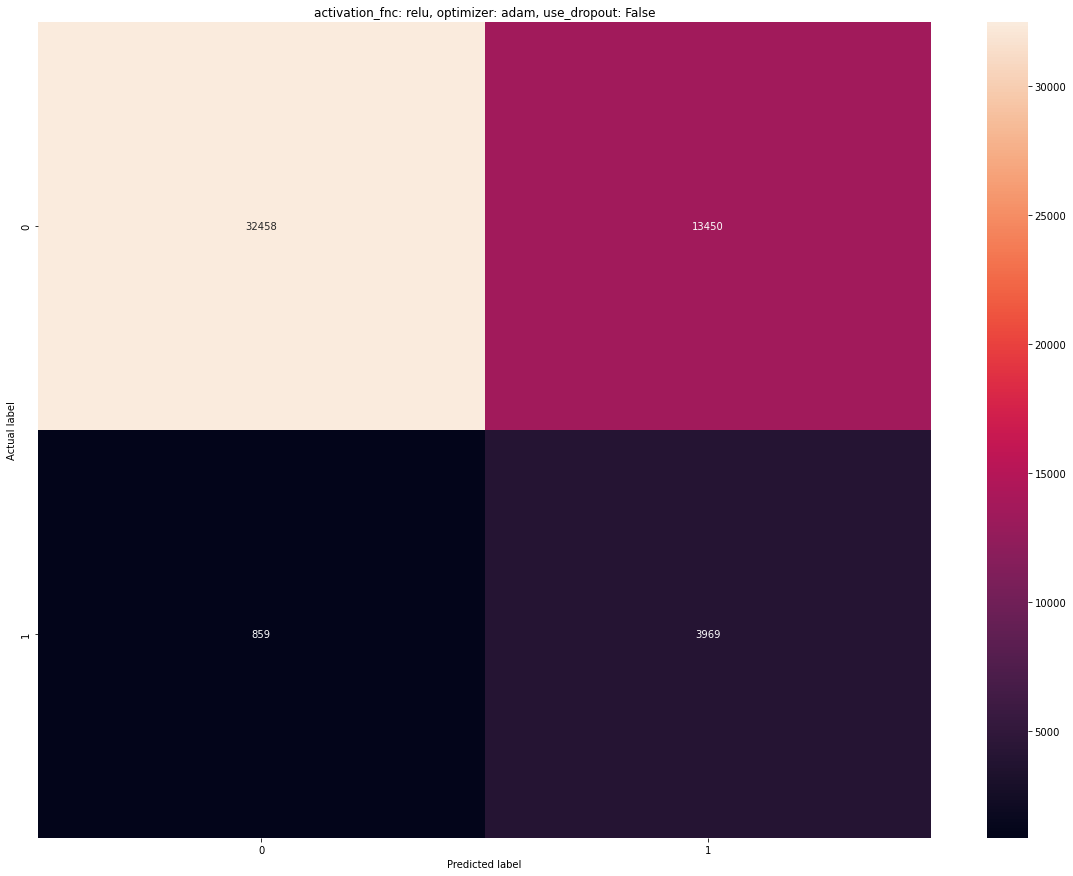

In [87]:
plot_cm([models[0]], test_dataset=True)

### Testing conclusion
Model has 72% accuracy, 82% recall and 23% precision on the testing dataset.